#### questions...

- [ ] does adding more participants increase regression $R^2$? (0.45 -> ??)
- [ ] can we do a dimensionality reduction with a vector including macros + spike? are there any clusters --> participants are sufficiently different? 
- [ ] run analysis without fiber
#### obs...
- In order of contribution for libre in regression by coefficients: fiber (-3.13), carbs (1.01), protein (0.41). fats (0.14) and overall calories (-0.087) aren't really correlated. --> makes a lot of sense actually. doesn't say anything about contribution
- About same $R^2$ for dexcom, similar coefficient magnitudes and same signs
- Adding all participants to the same df reduced correlation? --> seems like a personalized approach is needed...

In [29]:
import numpy as np 
import pandas as pd 
import sklearn as sk 
import matplotlib.pyplot as plt
from typing import Tuple
import glob

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.signal import find_peaks, peak_prominences

In [30]:
#constants/thresholds
HYPO = 70
GREEN = 80
YELLOW = 126
RED = 180
TOP = 300
    

In [31]:
def visualize(df: pd.DataFrame) -> None:
    
    len_data = len(df["Timestamp"])
    t = np.arange(0, len_data, 1)
    
    meals = np.where(df["Meal Type"] != 0)[0]
    days = np.arange(0, len_data, 1440) #each tick is a minute, 60 * 24 = 1440 minutes in a day
    
    fig, ax = plt.subplots(2, 1, figsize = (20, 20) )
    
    libre = df["Libre GL"]
    dexcom = df["Dexcom GL"]
    hr = df["HR"]
    
    peaks_lib, prop_lib = find_peaks(libre, prominence = 10)
    peaks_dex, prop_dex = find_peaks(dexcom, prominence = 10)
        
    #plot glucose
    ax[0].plot(t, libre, label = "libre", lw = 3)
    ax[0].plot(t, hr, label = "hr", alpha = 0.4, linestyle = "--")
    ax[0].plot(t[peaks_lib], libre[peaks_lib], "x")
    ax[0].set_title("Libre CGM Measurements")
    ax[0].legend()
    
    ax[1].plot(t, dexcom, label = "dexcom", lw = 3)
    ax[1].plot(t, hr, label = "hr", alpha = 0.4, linestyle = "--")
    ax[1].plot(t[peaks_dex], dexcom[peaks_dex], "x")
    ax[1].set_title("Dexcom CGM Measurements")
    ax[1].legend()

    for a in ax:
        a.axhspan(HYPO, GREEN, color = 'blue', alpha = 0.2)
        a.axhspan(GREEN, YELLOW, color = "green", alpha = 0.2)
        a.axhspan(YELLOW, RED, color = "yellow", alpha = 0.2)
        a.axhspan(RED, TOP, color = 'red', alpha = 0.2)

        for i in meals:
            a.axvline(i, color = "gray")
        
        for d in days:
            a.axvline(d, color = "black", lw = 3)
    
    plt.tight_layout()  
    plt.show()

In [32]:
def percent_healthy(df: pd.DataFrame, thresh_low: int = GREEN, thresh_high: int = YELLOW) -> Tuple:
    """Returns percent of indices that are in threshold range

    Args:
        df (pd.DataFrame): input dataframe

    Returns:
        Tuple(float, float): %healthy in (Libre, Dexcom)
    """
    lib = df["Libre GL"]
    dex = df["Dexcom GL"]
    
    ph_libre = np.sum((thresh_low < lib) & (lib < thresh_high)) / len(lib)
    ph_dexcom = np.sum((thresh_low < dex) & (dex < thresh_high)) / len(dex)
    
    return ph_libre, ph_dexcom


In [ ]:
def get_glucose_response(df: pd.DataFrame, unhealthy = True) -> pd.DataFrame:
    meals = df[df["Calories"] != 0].copy(deep=True) #get matrix of just meals and set index columns
    meals["idx"] = meals.index 
    
    libre = df["Libre GL"]
    dexcom = df["Dexcom GL"]
        
    peaks_lib, _ = find_peaks(libre, prominence = 10)
    _, lbase_lib, _ = peak_prominences(libre, peaks=peaks_lib) #just want indices of left value
    
    peaks_dex, _ = find_peaks(dexcom, prominence = 10)
    _, lbase_dex, _ = peak_prominences(dexcom, peaks=peaks_dex)

    
    spikes_lib = []
    spikes_dex = []
    for i in range(len(meals)): #iterate through all the meals
        
        curr_meal_idx = meals.iloc[i,-1]
        next_meal_idx = meals.iloc[i+1, -1] if i+1 < len(meals)-1 else len(df)
        
        #find first prominence after each meal --> LIBRE CGM
        next_peaks_lib = np.ravel(np.where((peaks_lib > curr_meal_idx) & (peaks_lib < next_meal_idx))) #idx #get all peak idxs greater than the location of this meal
        #get first spike and add
        if len(next_peaks_lib) > 0:
            if unhealthy: #just get the postmeal spikes that are in red range
                poss = [idx for idx in next_peaks_lib if libre[peaks_lib[idx]] > RED]
                if len(poss) == 0:
                    spikes_lib.append(None)
                else:
                    next_peak_idx = poss[0]
                    prom = libre[peaks_lib[next_peak_idx]] - libre[lbase_lib[next_peak_idx]] #get just left height
                    spikes_lib.append(prom)
            else:
                next_peak_idx = next_peaks_lib[0] #get next idx
                prom = libre[peaks_lib[next_peak_idx]] - libre[lbase_lib[next_peak_idx]] #get just left height
                spikes_lib.append(prom)
        else: #no next peak
            spikes_lib.append(None)
        
        #find first prominence after each meal --> DEXCOM CGM
        
        next_peaks_dex = np.ravel(np.where((peaks_dex > curr_meal_idx) & (peaks_dex < next_meal_idx)))
        if len(next_peaks_dex) > 0:
            if unhealthy: #just get the postmeal spikes that are in red range
                poss = [idx for idx in next_peaks_dex if dexcom[peaks_dex[idx]] > RED]
                if len(poss) == 0:
                    spikes_dex.append(None)
                else:
                    next_peak_idx = poss[0]
                    prom = dexcom[peaks_dex[next_peak_idx]] - dexcom[lbase_dex[next_peak_idx]]
                    spikes_dex.append(prom)
            else:
                next_peak_idx = next_peaks_dex[0]
                prom = dexcom[peaks_dex[next_peak_idx]] - dexcom[lbase_dex[next_peak_idx]]
                spikes_dex.append(prom)
        else: #no next peak
            spikes_dex.append(None)
    
    #checks
    print("lib", spikes_lib)
    print("dex", spikes_dex)
    
    meals["lib_prom"] = spikes_lib #make new columns
    meals["dex_prom"] = spikes_dex #make new columns
    
    meals = meals.dropna(subset=["lib_prom", "dex_prom"]) #remove meals who don't have a corresponding spike
    
    return meals

In [39]:
paths = glob.glob(r"../CGMacros/CGMacros-*/CGMacros-*.csv", recursive=True)

In [40]:
paths[0]

'../CGMacros/CGMacros-014/CGMacros-014.csv'

## Analysis for Single Participant 

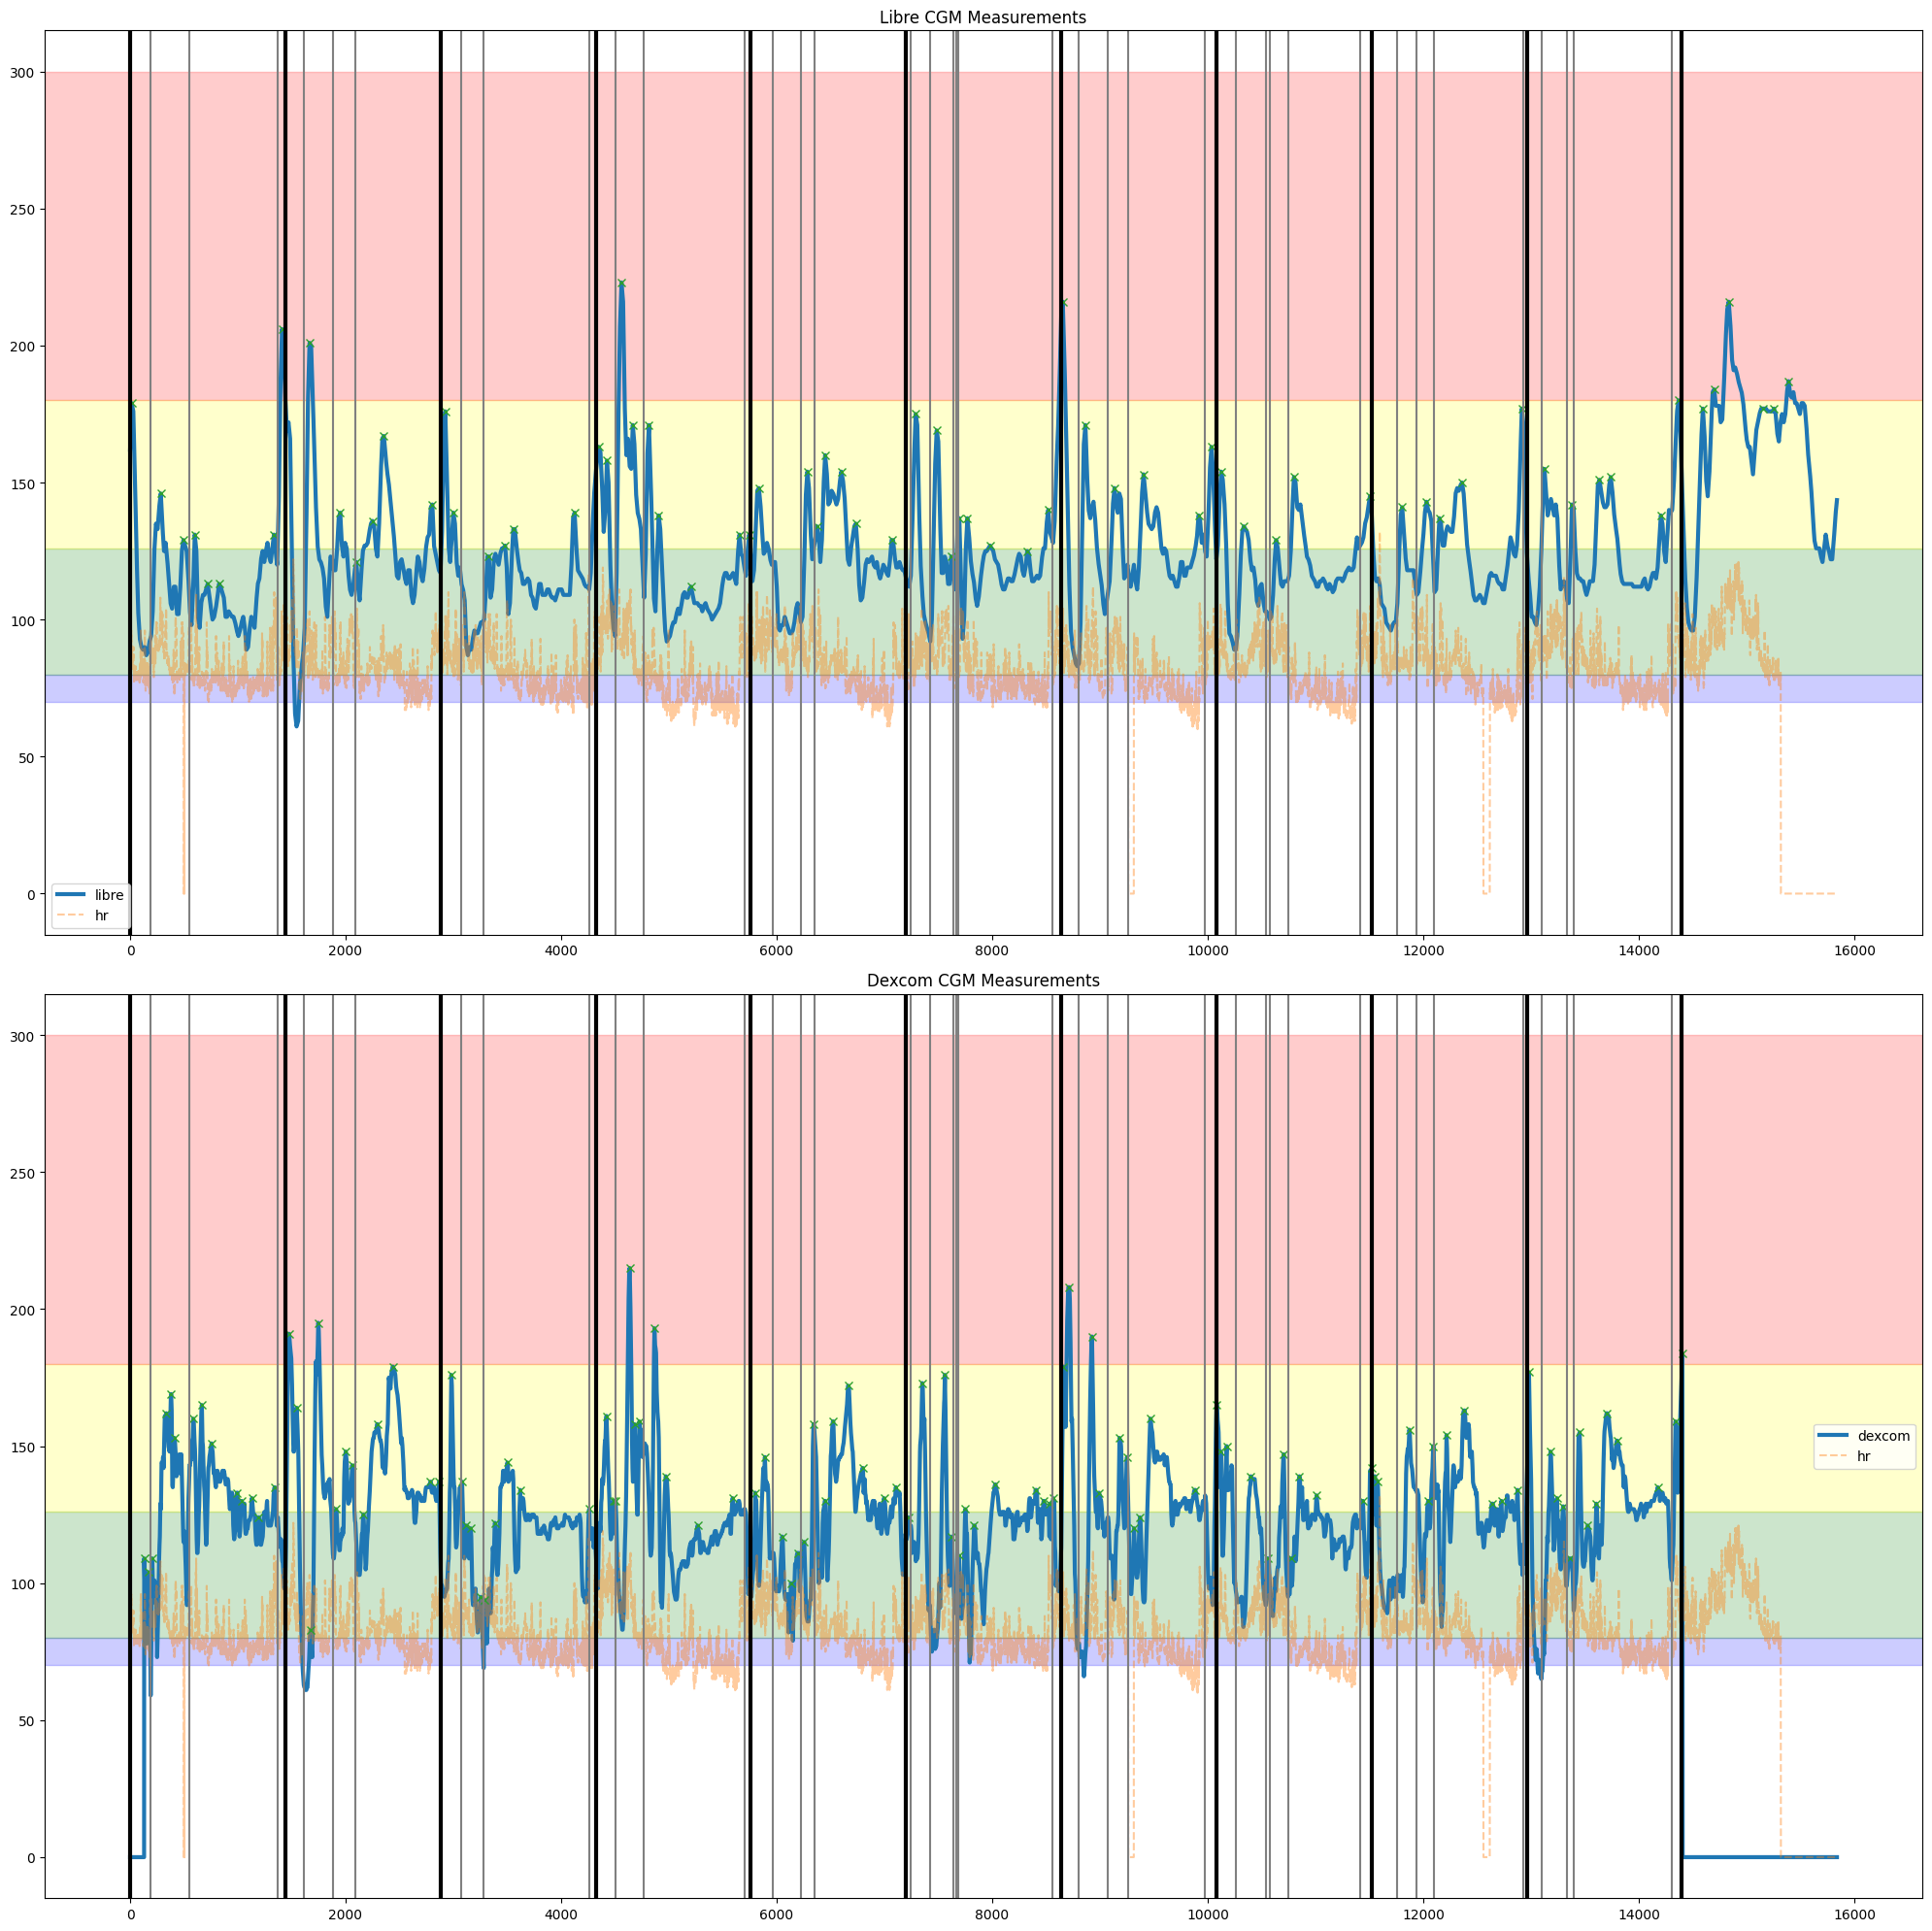

phlib 0.6037247474747475, phdex 0.48409090909090907


In [41]:
df = pd.read_csv(paths[1]).fillna(0)
visualize(df)
ph_lib, ph_dex = percent_healthy(df)

print(f"phlib {ph_lib}, phdex {ph_dex}")


In [42]:
mldf = get_glucose_response(df)
mldf

lib [None, None, 119.0, 140.0, None, None, None, None, None, None, 162.0, None, None, None, None, None, None, None, None, None, None, 124.0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 101.0, 101.0]
dex [None, 22.0, None, None, None, None, None, 108.0, None, None, None, None]


ValueError: Length of values (12) does not match length of index (39)

In [ ]:
X = mldf[['Calories', 'Carbs', 'Protein', 'Fat', 'Fiber']]
#X = mldf[['Calories', 'Carbs', 'Protein', 'Fat']]


y = mldf['dex_prom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Metrics
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

#plt.scatter(mldf["Fiber"], mldf["lib_prom"])


Coefficients: [ 0.71838622  0.14585976 -2.8823975 ]
Intercept: 56.83587486256296
Mean squared error (MSE): 3987.5459519343312
R^2 score: 0.1806552726286883


## Regression Analysis for All Participants

In [35]:
#get glucose response for all participants
mldf = get_glucose_response(df)
for path in paths:
    df = pd.read_csv(path).fillna(0)
    ml = get_glucose_response(df)
    
    mldf = pd.concat([mldf, ml], axis = 0)



lib [37.0, 26.0, 142.0, 28.0, 48.0, 54.0, 110.0, 89.0, 89.0, 89.0, 102.0, 142.0, 70.0, 70.0, 70.0, 101.0, 101.0, 15.0, 67.0, 57.0, 25.0, 145.0, 80.0, 53.0, 80.0, 135.0, 35.0, 41.0, 49.0, 49.0, 107.0, 27.0, 111.0, 18.0, 98.0, 79.0, 49.0, 49.0, 85.0]
dex [165.0, 33.0, 247.0, 34.0, 50.0, 59.0, 124.0, 40.0, 84.0, 84.0, 89.0, 147.0, 92.0, 92.0, 39.0, 13.0, 120.0, 34.0, 65.0, 73.0, 26.0, 267.0, 97.0, 70.0, 114.0, 158.0, 57.0, 58.0, 72.0, 72.0, 142.0, 37.0, 122.0, 12.0, 119.0, 93.0, 45.0, 45.0, None]
lib [37.0, 26.0, 142.0, 28.0, 48.0, 54.0, 110.0, 89.0, 89.0, 89.0, 102.0, 142.0, 70.0, 70.0, 70.0, 101.0, 101.0, 15.0, 67.0, 57.0, 25.0, 145.0, 80.0, 53.0, 80.0, 135.0, 35.0, 41.0, 49.0, 49.0, 107.0, 27.0, 111.0, 18.0, 98.0, 79.0, 49.0, 49.0, 85.0]
dex [165.0, 33.0, 247.0, 34.0, 50.0, 59.0, 124.0, 40.0, 84.0, 84.0, 89.0, 147.0, 92.0, 92.0, 39.0, 13.0, 120.0, 34.0, 65.0, 73.0, 26.0, 267.0, 97.0, 70.0, 114.0, 158.0, 57.0, 58.0, 72.0, 72.0, 142.0, 37.0, 122.0, 12.0, 119.0, 93.0, 45.0, 45.0, None]
li

In [36]:
X = mldf[['Calories', 'Carbs', 'Protein', 'Fat',
       'Fiber']]
y = mldf['dex_prom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Metrics
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

Coefficients: [ 0.02651612  0.18025856 -0.21117609 -0.14599131 -0.02248029]
Intercept: 67.78908898916801
Mean squared error (MSE): 4466.652531144202
R^2 score: 0.032418051190246766


Text(0, 0.5, 'PC 2')

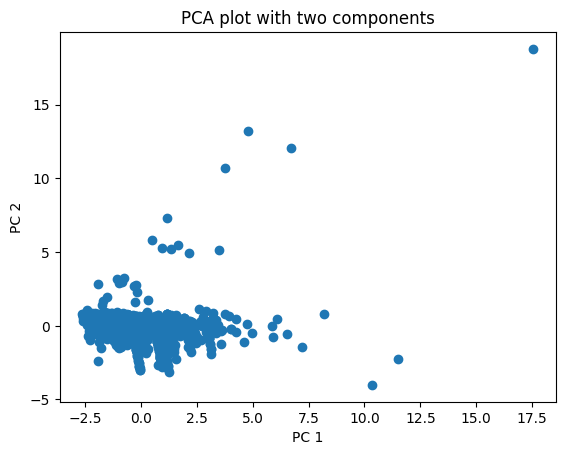

In [51]:
from sklearn.preprocessing import StandardScaler
X_all = mldf[['Calories', 'Carbs', 'Protein', 'Fat',
       'Fiber', "lib_prom"]]
X_np = X_all.to_numpy()
ss = StandardScaler()
X_sc = ss.fit_transform(X_all)

pca = PCA(n_components=2)
X_dimred = pca.fit_transform(X_sc)

plt.scatter(X_dimred[:, 0], X_dimred[:, 1])
plt.title("PCA plot with two components")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

## Testing

In [43]:
mldf["Carbs"]

170      81.0
600      46.0
1394     66.0
1663     92.0
1959     40.0
         ... 
9564     40.0
10598    66.0
11036    43.0
12016    24.0
12517    94.0
Name: Carbs, Length: 1700, dtype: float64

In [51]:
mldf.columns

Index(['Timestamp', 'Libre GL', 'Dexcom GL', 'HR', 'Calories (Activity)',
       'METs', 'Meal Type', 'Calories', 'Carbs', 'Protein', 'Fat', 'Fiber',
       'Amount Consumed', 'Image path', 'idx', 'lib_prom', 'dex_prom', 'Sugar',
       'Unnamed: 0', 'Intensity', 'Amount Consumed ', 'Steps', 'RecordIndex'],
      dtype='object')

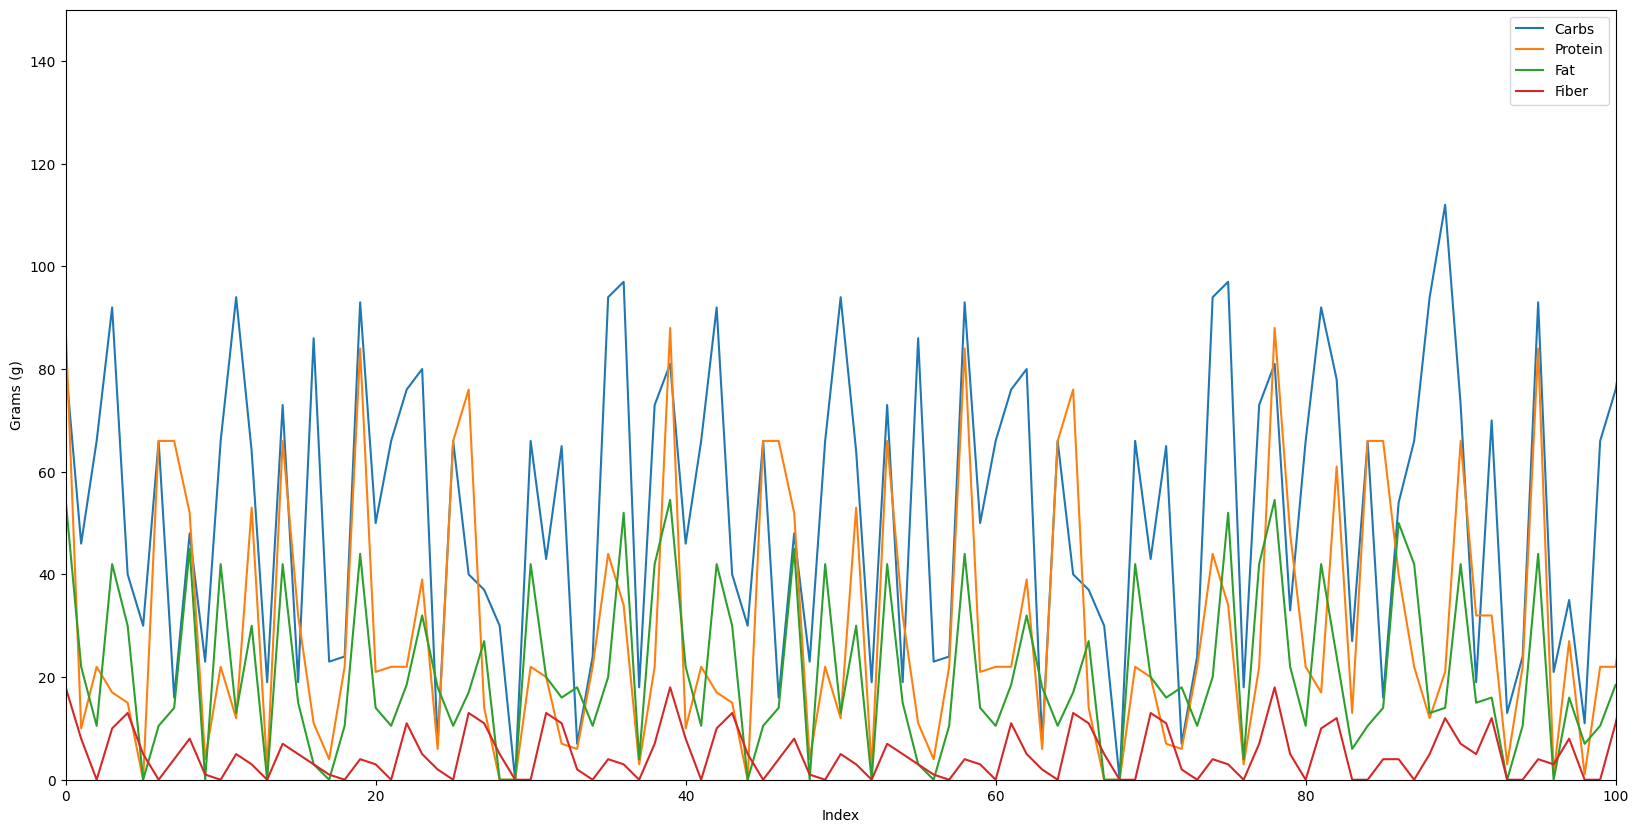

In [54]:
#plotting change in macros over time
plt.figure(figsize=(20,10))
t = np.arange(0,len(mldf["Carbs"]), 1)
plt.plot(t, mldf["Carbs"], label = "Carbs")
plt.plot(t, mldf["Protein"], label = "Protein")
plt.plot(t, mldf["Fat"], label = "Fat")
plt.plot(t, mldf["Fiber"], label = "Fiber")
plt.xlim(0, 100)
plt.ylim(0, 150)
plt.xlabel("Index")
plt.ylabel("Grams (g)")
plt.legend()

(array([490., 330., 522., 278.,  28.,  15.,   5.,   3.,   1.,   1.,   2.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.        ,  25.36666667,  50.73333333,  76.1       ,
        101.46666667, 126.83333333, 152.2       , 177.56666667,
        202.93333333, 228.3       , 253.66666667, 279.03333333,
        304.4       , 329.76666667, 355.13333333, 380.5       ,
        405.86666667, 431.23333333, 456.6       , 481.96666667,
        507.33333333, 532.7       , 558.06666667, 583.43333333,
        608.8       , 634.16666667, 659.53333333, 684.9       ,
        710.26666667, 735.63333333, 761.        ]),
 <BarContainer object of 30 artists>)

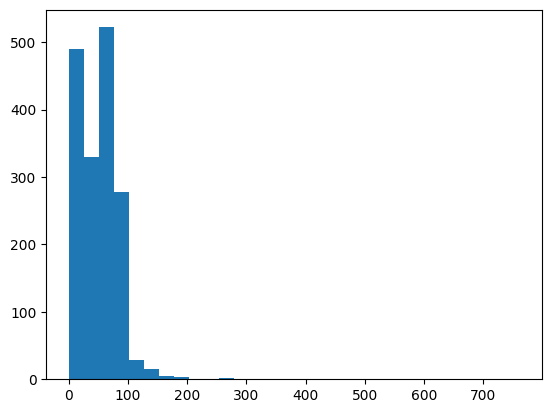

In [21]:
plt.hist(mldf["Carbs"], bins = 30)

In [30]:
mldf_meals65 = mldf[(mldf["Carbs"] < 70) & (mldf["Carbs"] > 60)]
for i in range(len(mldf_meals65)):
    print(mldf_meals65.iloc[i, 6:13])
    print()

Meal Type          breakfast
Calories               448.0
Carbs                   66.0
Protein                 22.0
Fat                     10.5
Fiber                    0.0
Amount Consumed        100.0
Name: 605, dtype: object

Meal Type          breakfast
Calories               608.0
Carbs                   66.0
Protein                 66.0
Fat                     10.5
Fiber                    0.0
Amount Consumed        100.0
Name: 1936, dtype: object

Meal Type          breakfast
Calories               712.0
Carbs                   66.0
Protein                 22.0
Fat                     42.0
Fiber                    0.0
Amount Consumed        100.0
Name: 3419, dtype: object

Meal Type          breakfast
Calories               448.0
Carbs                   66.0
Protein                 22.0
Fat                     10.5
Fiber                    0.0
Amount Consumed        100.0
Name: 7807, dtype: object

Meal Type          breakfast
Calories               608.0
Carbs                  

(0.0, 150.0)

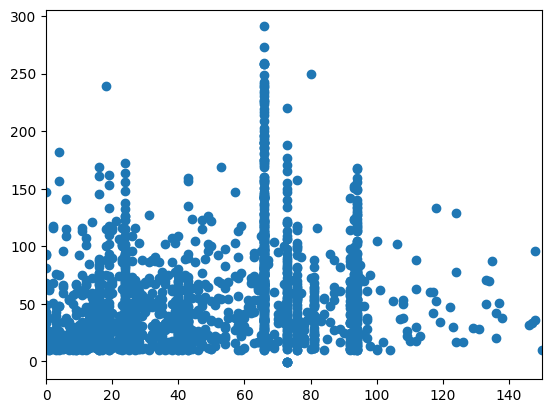

In [158]:
plt.scatter(mldf["Carbs"], mldf["lib_prom"])
plt.xlim(0, 150)

In [ ]:
X = mldf[['Calories', 'Carbs', 'Protein', 'Fat',
       'Fiber']]
y = mldf['lib_prom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Metrics
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))


Coefficients: [-0.00793351  0.22256291 -0.00624149  0.06363912 -0.0246382 ]
Intercept: 48.961522210093364
Mean squared error (MSE): 1923.5882038348373
R^2 score: 0.007670459891559345
